In [1]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

In [2]:
df= pd.read_csv("/content/warn_error.csv")

In [3]:
df1= df.copy()

In [4]:
df1

,static_text,log_level,preprocessed_text
0,No serialized RegionInfo in,warn,serial regioninfo
1,Ignoring invalid region for server | ; cell=,error,ignor invalid region server
2,Failed to parse the passed region name:,warn,fail pars pass region name
3,No serialized RegionInfo in,warn,serial regioninfo
4,Ignoring invalid region for server | ; cell=,error,ignor invalid region server
...,...,...,...
7062,failed to parse [*],error,fail pars
7063,could not update watcher stopped status to [*]...,error,could updat watcher stop statu sourc
7064,caught an interrupted exception when waiting w...,warn,caught interrupt except wait close ticker thread
7065,Unexpected failure,error,unexpect failur


In [5]:
df1['log_level'].value_counts()

warn     3755
error    3312
Name: log_level, dtype: int64

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
df1['preprocessed_text'].fillna('', inplace=True)
df1 = df1.dropna(subset=['preprocessed_text'])

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
# Feature extraction using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df1['preprocessed_text'])

In [10]:
# Label encoding
df1['log_level'] = df1['log_level'].map({'warn': 0, 'error': 1})
y = df['log_level']

In [11]:
df1

,static_text,log_level,preprocessed_text
0,No serialized RegionInfo in,0,serial regioninfo
1,Ignoring invalid region for server | ; cell=,1,ignor invalid region server
2,Failed to parse the passed region name:,0,fail pars pass region name
3,No serialized RegionInfo in,0,serial regioninfo
4,Ignoring invalid region for server | ; cell=,1,ignor invalid region server
...,...,...,...
7062,failed to parse [*],1,fail pars
7063,could not update watcher stopped status to [*]...,1,could updat watcher stop statu sourc
7064,caught an interrupted exception when waiting w...,0,caught interrupt except wait close ticker thread
7065,Unexpected failure,1,unexpect failur


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# Split the data into training (80%), validation (10%), and testing (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print('Train sets:')
print(X_train.shape)
print(y_train.shape)

print('Validation sets:')
print(X_val.shape)
print(y_val.shape)

print('Test sets:')
print(X_test.shape)
print(y_test.shape)

Train sets:
(5653, 2421)
(5653,)
Validation sets:
(707, 2421)
(707,)
Test sets:
(707, 2421)
(707,)


# ***Class-Imabalance***

In [14]:
# Check the distribution of classes before SMOTE
print("Distribution of classes in the original training set:")
print(pd.Series(y_train).value_counts())

Distribution of classes in the original training set:
warn     3037
error    2616
Name: log_level, dtype: int64


In [15]:
# Apply SMOTE for balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [16]:
# Check the distribution of classes after SMOTE
print("Distribution of classes in the training set after SMOTEENN:")
print(pd.Series(y_resampled).value_counts())

Distribution of classes in the training set after SMOTEENN:
error    3037
warn     3037
Name: log_level, dtype: int64


# ***Hyper-parameter tunning***

In [17]:
# Hyper-parameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

## **Model: RF**

In [18]:
from sklearn.ensemble import RandomForestClassifier

In [19]:
model=RandomForestClassifier()
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
# Get the best parameters from the grid search
best_params = grid_search.best_params_
#model.fit(X_resampled, y_resampled)


In [20]:
# Train the model with the best parameters
best_model = RandomForestClassifier(random_state=42, **best_params)
best_model.fit(X_resampled, y_resampled)

RandomForestClassifier(random_state=42)

Validation Set Results:
Accuracy: 0.7227722772277227
              precision    recall  f1-score   support

       error       0.71      0.70      0.71       335
        warn       0.74      0.74      0.74       372

    accuracy                           0.72       707
   macro avg       0.72      0.72      0.72       707
weighted avg       0.72      0.72      0.72       707

MCC: 0.44386385331270545
[[236  99]
 [ 97 275]]


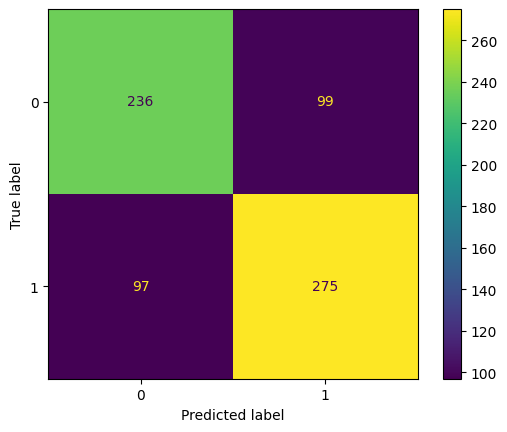

In [21]:
# Evaluate the model on the validation set
y_val_pred = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)

print("Validation Set Results:")
print(f"Accuracy: {accuracy_val}")
print(report_val)
print(f"MCC: {mcc_val}")
print(conf_matrix_val)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

Test Set Results:
Accuracy: 0.7454031117397454
              precision    recall  f1-score   support

       error       0.75      0.75      0.75       361
        warn       0.74      0.74      0.74       346

    accuracy                           0.75       707
   macro avg       0.75      0.75      0.75       707
weighted avg       0.75      0.75      0.75       707

MCC: 0.4906459412250476
[[270  91]
 [ 89 257]]


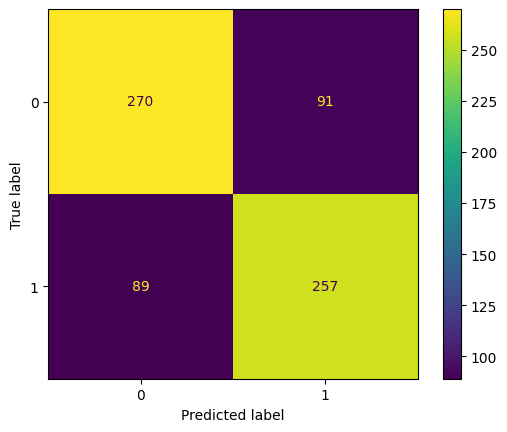

In [22]:
# Evaluate the model on the test set
y_test_pred = best_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_val = confusion_matrix(y_test, y_test_pred)


print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print(report_test)
print(f"MCC: {mcc_test}")
print(conf_matrix_val)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

In [23]:
# Random Forest Model
print("Random Forest Model Results:")
y_rf_pred = best_model.predict(X_test)
incorrect_rf_indices = y_test != y_rf_pred
correct_rf_indices = y_test == y_rf_pred

incorrect_rf_texts = df1.loc[y_test.index[incorrect_rf_indices], 'preprocessed_text']
true_rf_labels = y_test[incorrect_rf_indices]
predicted_rf_labels = y_rf_pred[incorrect_rf_indices]

print("\nRecords where Random Forest model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_rf_texts.index, incorrect_rf_texts, true_rf_labels, predicted_rf_labels):
    print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")

Random Forest Model Results:

Records where Random Forest model failed to predict the labels:
Index: 3891, Text: could build cipher, True Label: error, Predicted Label: warn
Index: 1261, Text: fail instanti remot procedur, True Label: warn, Predicted Label: error
Index: 5876, Text: sasl authent zookeep quorum member fail, True Label: error, Predicted Label: warn
Index: 6513, Text: empti messag, True Label: warn, Predicted Label: error
Index: 5962, Text: fixmsg, True Label: error, Predicted Label: warn
Index: 7062, Text: fail pars, True Label: error, Predicted Label: warn
Index: 6246, Text: send except, True Label: warn, Predicted Label: error
Index: 5451, Text: modif time key store could obtain, True Label: error, Predicted Label: warn
Index: 4897, Text: determin memori architectur use pure shuffl, True Label: warn, Predicted Label: error
Index: 3169, Text: endrow call twice success, True Label: warn, Predicted Label: error
Index: 3914, Text: error load counter cach, True Label: warn, 

In [24]:
    # Identify indices where predictions are incorrect
    incorrect_indices = y_test != y_test_pred

    # Extract the original texts and corresponding true labels
    incorrect_texts = df.loc[y_test.index[incorrect_indices], 'preprocessed_text']
    true_labels = y_test[incorrect_indices]
    predicted_labels = y_test_pred[incorrect_indices]

    # Print the records where the model failed to predict the labels
    print(f"\nRecords where {best_model} failed to predict labels:")
    for idx, text, true_label, pred_label in zip(incorrect_texts.index, incorrect_texts, true_labels, predicted_labels):
        print(f"Index: {idx}")
        print(f"True Labels: {true_label}")
        print(f"Predicted Labels: {pred_label}")
        print(f"Text: {text}\n")


Records where RandomForestClassifier(random_state=42) failed to predict labels:
Index: 3891
True Labels: error
Predicted Labels: warn
Text: could build cipher

Index: 1261
True Labels: warn
Predicted Labels: error
Text: fail instanti remot procedur

Index: 5876
True Labels: error
Predicted Labels: warn
Text: sasl authent zookeep quorum member fail

Index: 6513
True Labels: warn
Predicted Labels: error
Text: empti messag

Index: 5962
True Labels: error
Predicted Labels: warn
Text: fixmsg

Index: 7062
True Labels: error
Predicted Labels: warn
Text: fail pars

Index: 6246
True Labels: warn
Predicted Labels: error
Text: send except

Index: 5451
True Labels: error
Predicted Labels: warn
Text: modif time key store could obtain

Index: 4897
True Labels: warn
Predicted Labels: error
Text: determin memori architectur use pure shuffl

Index: 3169
True Labels: warn
Predicted Labels: error
Text: endrow call twice success

Index: 3914
True Labels: warn
Predicted Labels: error
Text: error load coun

In [25]:
correct_rf_texts = df1.loc[y_test.index[correct_rf_indices], 'preprocessed_text']
correct_true_rf_labels = y_test[correct_rf_indices]
correct_predicted_rf_labels = y_rf_pred[correct_rf_indices]

print("\nRecords where Random Forest model predicted the labels correctly:")
for idx, text, true_label, pred_label in zip(correct_rf_texts.index, correct_rf_texts, correct_true_rf_labels, correct_predicted_rf_labels):
    print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")


Records where Random Forest model predicted the labels correctly:
Index: 6645, Text: error notifi global checkpoint listen updat global checkpoint, True Label: warn, Predicted Label: warn
Index: 4690, Text: jdbc connect could close, True Label: warn, Predicted Label: warn
Index: 1020, Text: fail creat del writer continu compact write delet marker directli store file, True Label: warn, Predicted Label: warn
Index: 17, Text: waitfortermin interrupt, True Label: warn, Predicted Label: warn
Index: 6656, Text: fail lock shard index interrupt, True Label: warn, Predicted Label: warn
Index: 3771, Text: pick random token singl vnode probabl add vnode use automat token alloc mechan, True Label: warn, Predicted Label: warn
Index: 5746, Text: close open iter store, True Label: warn, Predicted Label: warn
Index: 1034, Text: task may stuck, True Label: warn, Predicted Label: warn
Index: 2464, Text: tapplicationexcept insid handler, True Label: error, Predicted Label: error
Index: 5156, Text: objec

In [26]:
    # Identify indices where predictions are incorrect
    incorrect_indices = y_test != y_test_pred

    # Extract the original texts and corresponding true labels
    incorrect_texts = df.loc[y_test.index[incorrect_indices], 'preprocessed_text']
    true_labels = y_test[incorrect_indices]
    predicted_labels = y_test_pred[incorrect_indices]

    # Print the records where the model failed to predict the labels
    print(f"\nRecords where {best_model} failed to predict labels:")
    for idx, text, true_label, pred_label in zip(incorrect_texts.index, incorrect_texts, true_labels, predicted_labels):
        print(f"Index: {idx}")
        print(f"True Labels: {true_label}")
        print(f"Predicted Labels: {pred_label}")
        print(f"Text: {text}\n")


Records where RandomForestClassifier(random_state=42) failed to predict labels:
Index: 3891
True Labels: error
Predicted Labels: warn
Text: could build cipher

Index: 1261
True Labels: warn
Predicted Labels: error
Text: fail instanti remot procedur

Index: 5876
True Labels: error
Predicted Labels: warn
Text: sasl authent zookeep quorum member fail

Index: 6513
True Labels: warn
Predicted Labels: error
Text: empti messag

Index: 5962
True Labels: error
Predicted Labels: warn
Text: fixmsg

Index: 7062
True Labels: error
Predicted Labels: warn
Text: fail pars

Index: 6246
True Labels: warn
Predicted Labels: error
Text: send except

Index: 5451
True Labels: error
Predicted Labels: warn
Text: modif time key store could obtain

Index: 4897
True Labels: warn
Predicted Labels: error
Text: determin memori architectur use pure shuffl

Index: 3169
True Labels: warn
Predicted Labels: error
Text: endrow call twice success

Index: 3914
True Labels: warn
Predicted Labels: error
Text: error load coun

In [27]:
# Identify indices where predictions are correct
correct_indices = y_test == y_test_pred

# Extract the original texts and corresponding true labels
correct_texts = df1.loc[y_test.index[correct_indices], 'preprocessed_text']
correct_true_labels = y_test[correct_indices]
correct_predicted_labels = y_test_pred[correct_indices]

# Print the records where the model predicted the labels correctly
print(f"\nRecords where {best_model} predicted labels correctly:")
for idx, text, true_label, pred_label in zip(correct_texts.index, correct_texts, correct_true_labels, correct_predicted_labels):
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where RandomForestClassifier(random_state=42) predicted labels correctly:
Index: 6645
True Labels: warn
Predicted Labels: warn
Text: error notifi global checkpoint listen updat global checkpoint

Index: 4690
True Labels: warn
Predicted Labels: warn
Text: jdbc connect could close

Index: 1020
True Labels: warn
Predicted Labels: warn
Text: fail creat del writer continu compact write delet marker directli store file

Index: 17
True Labels: warn
Predicted Labels: warn
Text: waitfortermin interrupt

Index: 6656
True Labels: warn
Predicted Labels: warn
Text: fail lock shard index interrupt

Index: 3771
True Labels: warn
Predicted Labels: warn
Text: pick random token singl vnode probabl add vnode use automat token alloc mechan

Index: 5746
True Labels: warn
Predicted Labels: warn
Text: close open iter store

Index: 1034
True Labels: warn
Predicted Labels: warn
Text: task may stuck

Index: 2464
True Labels: error
Predicted Labels: error
Text: tapplicationexcept insid handler

Index: 5

done
done
['warn' 'error' 'warn' 'warn' 'warn' 'warn' 'error' 'warn' 'error']
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[5 0]
 [4 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


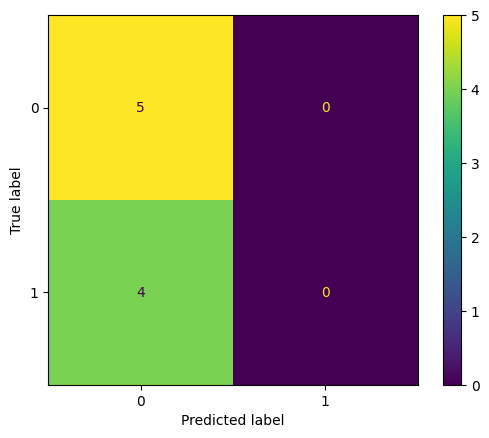

In [28]:
#Using RF

#This need tobe edited for we and  wi


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Referred to https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb226812(v=vs.85) to construct representative log messages.
messages = ["Out of memory", "File format does not match required format","Division by zero is undefined", "Unused import 'unused_function'", "File not found", "Could not complete operation index out of bounds.", "missing parentheses in call to 'example_function'", "This function is deprecated, use new_function instead", "Timeout system connection could not be established"]
#The codding for the log messages is: {wARN: 1, ERROR:0}.
true_labels = [0,0,1,1,0,0,1,1,0]

#Feature extraction using TF-IDF
message_Vect = tfidf_vectorizer.transform(messages)
print('done')
predicted_labels = best_model.predict(message_Vect)
predicted_lables_bin = []
for i in predicted_labels:
    if i=='info':
        predicted_lables_bin.append(1)
    else:
        predicted_lables_bin.append(0)

print('done')
#Calculates accuracy
accuracy = accuracy_score(true_labels,predicted_lables_bin)
print(predicted_labels)
#Calculate precision, recall, and F1 score
precision = precision_score(true_labels,predicted_lables_bin)
recall = recall_score(true_labels, predicted_lables_bin)
f1 = f1_score(true_labels, predicted_lables_bin)

#Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_lables_bin)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_lables_bin)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

## **Model: SVM**

In [29]:
from sklearn.svm import SVC

In [30]:
# Define the hyperparameter grid to search
param_grid = {
    'C': [0.1, 1, 10, 25],
    'gamma': ['scale', 'auto', 0.1, 1, 10]
}

In [31]:
model1 = SVC(probability=True)
grid_search = GridSearchCV(estimator=model1, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_resampled, y_resampled)
# Get the best parameters from the grid search
best_params = grid_search.best_params_

#model.fit(X_resampled, y_resampled)
#model1.fit(X_train, y_train)

In [32]:
# Train the model with the best hyperparameters
best_model1 = SVC(probability=True,**best_params)
best_model1.fit(X_resampled, y_resampled)

SVC(C=25, probability=True)

Validation Set Results:
Accuracy: 0.7454031117397454
MCC: 0.48884599043368987
Confusion Matrix:
 [[240  95]
 [ 85 287]]
              precision    recall  f1-score   support

       error       0.74      0.72      0.73       335
        warn       0.75      0.77      0.76       372

    accuracy                           0.75       707
   macro avg       0.74      0.74      0.74       707
weighted avg       0.75      0.75      0.75       707



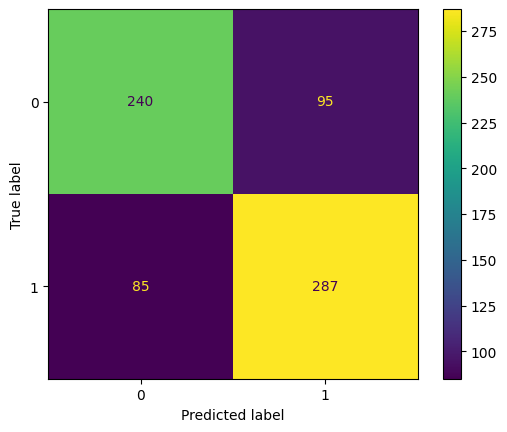

In [33]:
# Evaluate the SVM model on the validation set
y_val_pred = best_model1.predict(X_val)
accuracy_val = accuracy_score(y_val, y_val_pred)
mcc_val = matthews_corrcoef(y_val, y_val_pred)
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
report_val = classification_report(y_val, y_val_pred)

print("Validation Set Results:")
print(f"Accuracy: {accuracy_val}")
print(f"MCC: {mcc_val}")
print("Confusion Matrix:\n", conf_matrix_val)
print(report_val)


import matplotlib.pyplot as plt
cm = confusion_matrix(y_val, y_val_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

Test Set Results:
Accuracy: 0.768033946251768
MCC: 0.5358589659423887
Confusion Matrix:
 [[279  82]
 [ 82 264]]
              precision    recall  f1-score   support

       error       0.77      0.77      0.77       361
        warn       0.76      0.76      0.76       346

    accuracy                           0.77       707
   macro avg       0.77      0.77      0.77       707
weighted avg       0.77      0.77      0.77       707



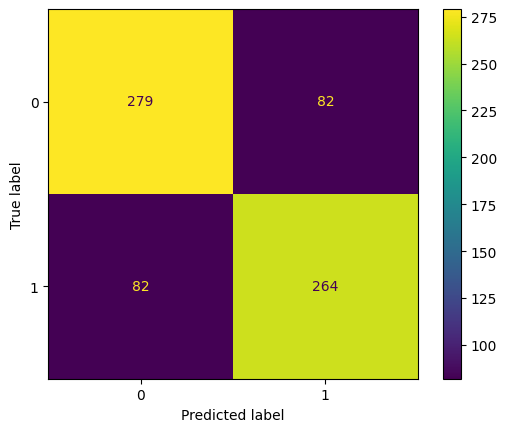

In [34]:
# Evaluate the SVM model on the test set
y_test_pred = best_model1.predict(X_test)
accuracy_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
report_test = classification_report(y_test, y_test_pred)

print("Test Set Results:")
print(f"Accuracy: {accuracy_test}")
print(f"MCC: {mcc_test}")
print("Confusion Matrix:\n", conf_matrix_test)
print(report_test)

import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_test_pred)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()

In [35]:
print("\nSVM Model Results:")
y_svm_pred = best_model1.predict(X_test)
incorrect_svm_indices = y_test != y_svm_pred
correct_svm_indices = y_test == y_svm_pred


SVM Model Results:


In [36]:
incorrect_svm_texts = df1.loc[y_test.index[incorrect_svm_indices], 'preprocessed_text']
true_svm_labels = y_test[incorrect_svm_indices]
predicted_svm_labels = y_svm_pred[incorrect_svm_indices]

print("\nRecords where svm model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_svm_texts.index, incorrect_svm_texts, true_svm_labels, predicted_svm_labels):
    #print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where svm model failed to predict the labels:
Index: 3891
True Labels: error
Predicted Labels: warn
Text: could build cipher

Index: 6513
True Labels: warn
Predicted Labels: error
Text: empti messag

Index: 5156
True Labels: warn
Predicted Labels: error
Text: object exist fail recoveri commit mpu id

Index: 5962
True Labels: error
Predicted Labels: warn
Text: fixmsg

Index: 7062
True Labels: error
Predicted Labels: warn
Text: fail pars

Index: 6246
True Labels: warn
Predicted Labels: error
Text: send except

Index: 5451
True Labels: error
Predicted Labels: warn
Text: modif time key store could obtain

Index: 3169
True Labels: warn
Predicted Labels: error
Text: endrow call twice success

Index: 3914
True Labels: warn
Predicted Labels: error
Text: error load counter cach

Index: 4764
True Labels: warn
Predicted Labels: error
Text: queryabl state client shutdown fail

Index: 5927
True Labels: warn
Predicted Labels: error
Text: sasl client unexpectedli null respond zookeep server


In [37]:

correct_svm_texts = df1.loc[y_test.index[correct_svm_indices], 'preprocessed_text']
correct_true_svm_labels = y_test[correct_svm_indices]
correct_predicted_svm_labels = y_rf_pred[correct_svm_indices]

In [38]:
print("\nRecords where svm model failed to predict the labels:")
for idx, text, true_label, pred_label in zip(incorrect_svm_texts.index, incorrect_svm_texts, true_svm_labels, predicted_svm_labels):
   # print(f"Index: {idx}, Text: {text}, True Label: {true_label}, Predicted Label: {pred_label}")
    print(f"Index: {idx}")
    print(f"True Labels: {true_label}")
    print(f"Predicted Labels: {pred_label}")
    print(f"Text: {text}\n")


Records where svm model failed to predict the labels:
Index: 3891
True Labels: error
Predicted Labels: warn
Text: could build cipher

Index: 6513
True Labels: warn
Predicted Labels: error
Text: empti messag

Index: 5156
True Labels: warn
Predicted Labels: error
Text: object exist fail recoveri commit mpu id

Index: 5962
True Labels: error
Predicted Labels: warn
Text: fixmsg

Index: 7062
True Labels: error
Predicted Labels: warn
Text: fail pars

Index: 6246
True Labels: warn
Predicted Labels: error
Text: send except

Index: 5451
True Labels: error
Predicted Labels: warn
Text: modif time key store could obtain

Index: 3169
True Labels: warn
Predicted Labels: error
Text: endrow call twice success

Index: 3914
True Labels: warn
Predicted Labels: error
Text: error load counter cach

Index: 4764
True Labels: warn
Predicted Labels: error
Text: queryabl state client shutdown fail

Index: 5927
True Labels: warn
Predicted Labels: error
Text: sasl client unexpectedli null respond zookeep server


done
done
['error' 'warn' 'error' 'warn' 'warn' 'warn' 'error' 'warn' 'error']
Accuracy: 0.56
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
Confusion Matrix:
[[5 0]
 [4 0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


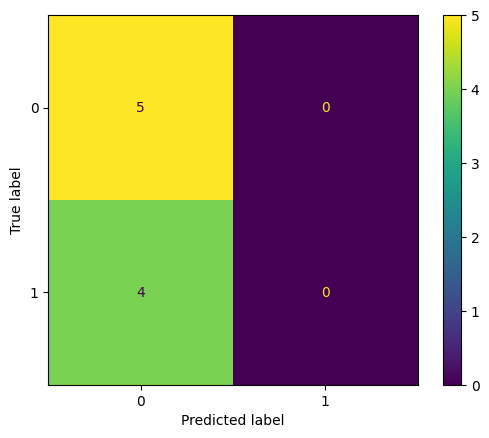

In [39]:
# Using SVM


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix#, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Referred to https://learn.microsoft.com/en-us/previous-versions/windows/desktop/bb226812(v=vs.85) to construct representative log messages.
messages = ["Out of memory", "File format does not match required format","Division by zero is undefined", "Unused import 'unused_function'", "File not found", "Could not complete operation index out of bounds.", "missing parentheses in call to 'example_function'", "This function is deprecated, use new_function instead", "Timeout system connection could not be established"]
#The codding for the log messages is: {wARN: 1, ERROR:0}.
true_labels = [0,0,1,1,0,0,1,1,0]

#Feature extraction using TF-IDF
message_Vect = tfidf_vectorizer.transform(messages)
print('done')
predicted_labels = best_model1.predict(message_Vect)
predicted_lables_bin = []
for i in predicted_labels:
    if i=='info':
        predicted_lables_bin.append(1)
    else:
        predicted_lables_bin.append(0)

print('done')
#Calculates accuracy
accuracy = accuracy_score(true_labels,predicted_lables_bin)
print(predicted_labels)
#Calculate precision, recall, and F1 score
precision = precision_score(true_labels,predicted_lables_bin)
recall = recall_score(true_labels, predicted_lables_bin)
f1 = f1_score(true_labels, predicted_lables_bin)

#Calculate confusion matrix
confusion = confusion_matrix(true_labels, predicted_lables_bin)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(confusion)

import matplotlib.pyplot as plt
cm = confusion_matrix(true_labels, predicted_lables_bin)
cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['0', '1'])
cmd_obj.plot()

plt.show()